# Arrival Time Prediction - Synchronisation
This notebook is the second on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import plot
import GPy
import gp_gpy as gp
import synch

version = 3
train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

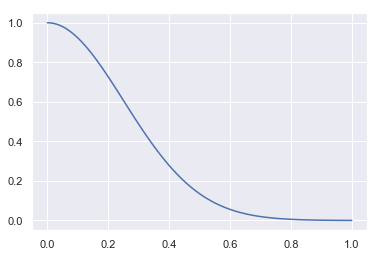

In [17]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

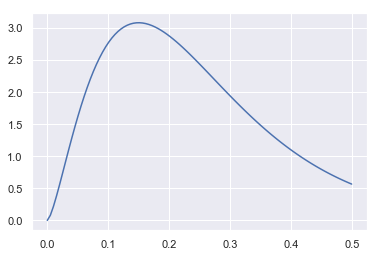

In [18]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

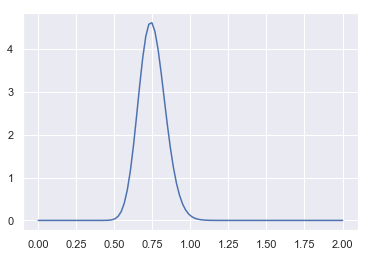

In [19]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

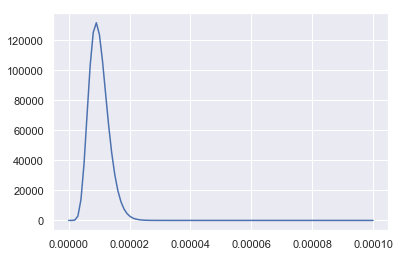

In [20]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [21]:
d_lat = train.lat.max() - train.lat.min()
d_lon = train.lon.max() - train.lon.min()
print(d_lat, d_lon)

0.047312736511198494 0.00957489013679691


## Mean time_left
Started to figure out mean time_left trajectory for each segment

In [22]:
print(train.traj.unique())

segments = {}

curr_seg = 0
for x in train.itertuples():
    if x.seg != curr_seg:
        #print(x)
        
        tup = (x.time_left, x.traj)
        
        if x.seg in segments:
            segments[x.seg].append(tup)
        else:
            segments[x.seg] = [tup]
        
        curr_seg = x.seg
        
#print(segments)
        
for s, traj_list in segments.items():
    traj_list.sort()
    print(traj_list)

[  24   79   82   95  109  123  227  228  233  281  320  339  346  355
  385  390  412  445  486  516  522  550  577  598  627  636  695  706
  718  838  868  896  907  953 1029 1045 1070 1073 1104 1113 1127 1133
 1165 1166 1167 1187 1228 1276 1309 1332 1355 1422 1441 1447 1499 1526
 1546 1590 1609 1628 1640 1645 1662 1675 1704 1737 1760 1765 1802 1818
 1827 1828 1830 1851 1855 1892 1904 1906 1913 1914 1937 1983 2008 2015
 2116 2118 2151 2168 2187 2189 2198 2203 2211 2237 2258 2297 2308 2347
 2353 2384 2388 2422 2479 2483 2492 2501 2630 2667 2669 2670 2703 2707
 2724 2806 2817 2840 2841 2855 2861 2866 2877 2886 2903 2976 2991 3053
 3133 3187 3188 3206 3207 3213 3221 3249 3278 3299 3361 3370 3376 3379
 3385 3393 3395 3419 3422 3436 3449 3474 3504 3556 3561 3575 3592 3595
 3622]
[(22.0, 1104), (24.0, 1165), (24.0, 1904), (25.0, 522), (26.0, 896), (26.0, 2866), (27.0, 2353), (28.0, 1645), (28.0, 2991), (30.0, 3622), (31.0, 1737), (31.0, 3419), (32.0, 2258), (33.0, 82), (33.0, 3575), (34.0

In [23]:
train[train.traj == 24]

,lat,lon,traj,seg,speed,time_left,progress
0,15.564935,58.414526,24,2,4.32,56.0,0.000000
1,15.564674,58.414425,24,2,-1.00,41.0,0.026316
2,15.564879,58.414508,24,2,3.75,38.0,0.052632
3,15.564745,58.414452,24,2,4.73,35.0,0.078947
4,15.564674,58.414425,24,2,5.19,35.0,0.105263
5,15.564578,58.414387,24,2,6.43,33.0,0.131579
6,15.564485,58.414349,24,2,6.84,32.0,0.157895
7,15.564386,58.414310,24,2,7.35,31.0,0.184211
8,15.564281,58.414268,24,2,7.81,30.0,0.210526
9,15.564164,58.414219,24,2,8.38,29.0,0.236842


## Utility functions

The functions below are used to find the haversine distance between two GPS points and given some data and contstant `c`, find reasonable values for the length scale `l` and its variance. This is done by finding the greatest distance in the Y/X axis, and then using the biggest of those two together with the number of points and `c`.

In [24]:
from math import radians, cos, sin, asin, sqrt, isnan

def haversine(lon1, lat1, lon2, lat2):
    """
   Calculate the great circle distance between two points
   on the earth (specified in decimal degrees)
   """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

def calculate_l(data, c):
    N = len(data)

    dy = haversine(np.min(data.lon), 0, np.max(data.lon), 0)
    dx = haversine(0, np.min(data.lat), 0, np.max(data.lat))
    maxd = np.max([dx, dy])

    l = (maxd/N)*c
    var = 0.1
    
    return l, var

# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

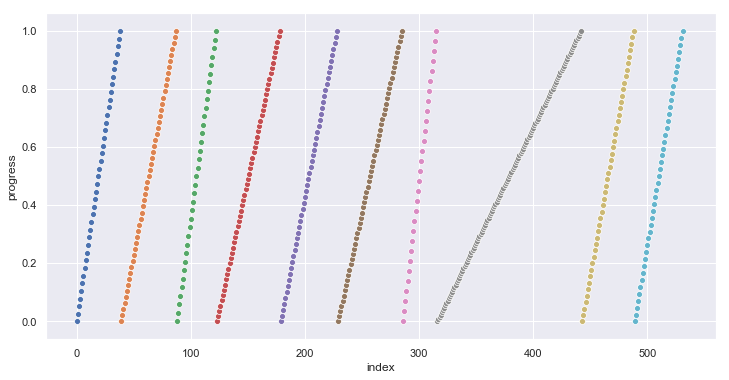

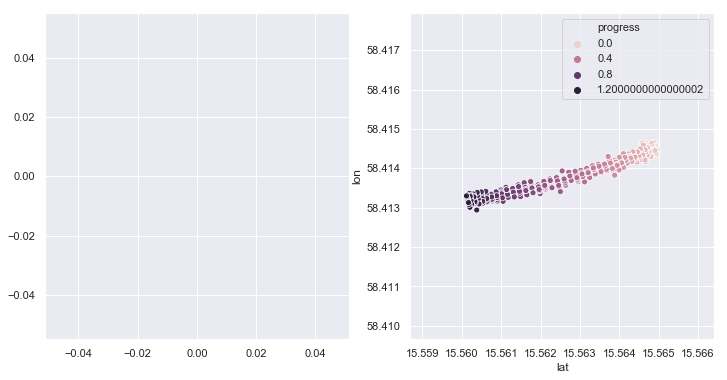

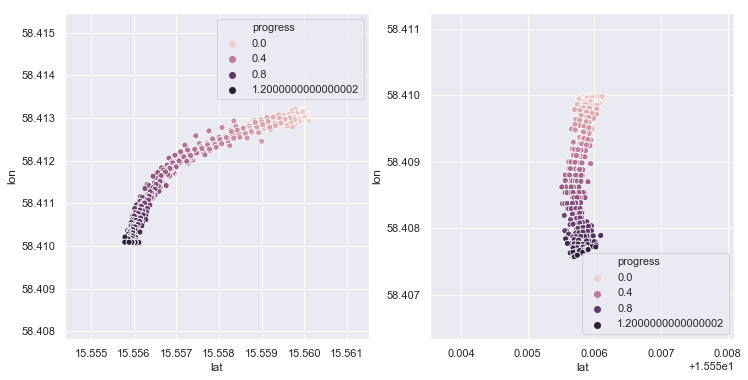

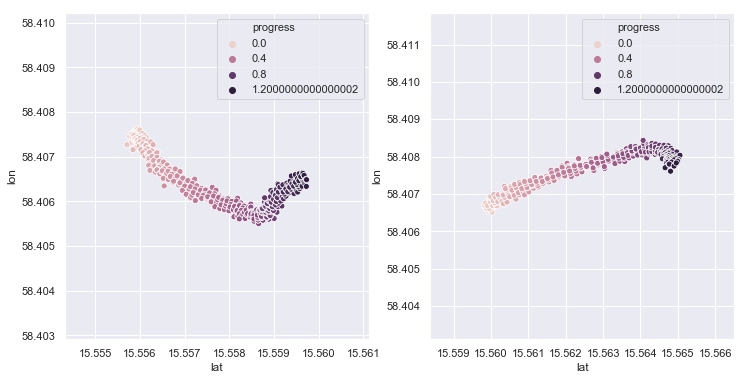

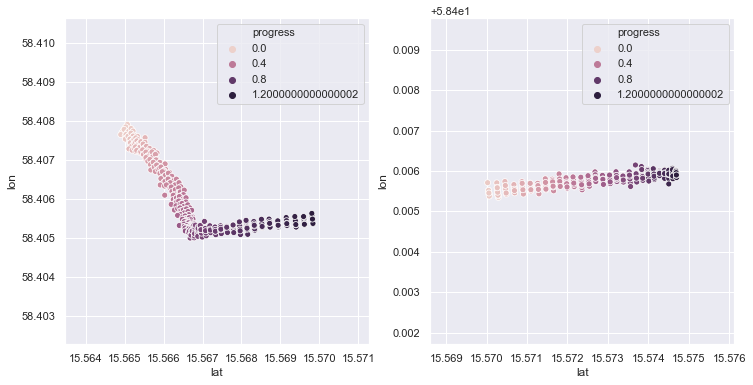

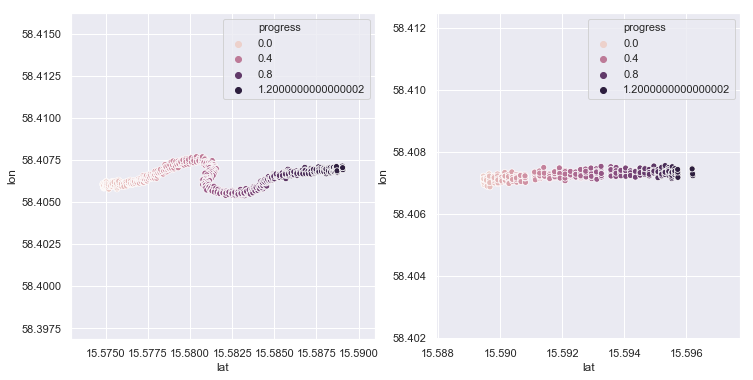

In [25]:
n_trajs = train.traj.unique()
traj_n = n_trajs[2]
traj_n = 24
traj = train[train.traj == traj_n]
traj_support = support[support.traj == traj_n]
train_traj = traj.append(traj_support)
plot.traj_progress(traj)
plot.traj_segment_grid(train_traj, 'lat', 'lon', hue='progress')

Having found a seg_n that seems typical we can now fit GPs for each of its segments. The length scales are calculated for each segment since their geographical and speed characteristics differ somewhat.

In [31]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    d_lat = train.lat.max() - train.lat.min()
    d_lon = train.lon.max() - train.lon.min()
    X = seg[['lat', 'lon']].values
    Y = seg[['progress']]
    model = gp.build_synch(X, Y, version, route_n, seg_n)
    
    l_mean, l_var = calculate_l(seg, 1500)
    print("THEM PRIORS", l_mean, l_var)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(l_mean, l_var))
    model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.2))
    model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.005, 0.00001))
    #model.model.likelihood.variance = 0.0003
    #model.model.likelihood.variance.fix()
    gp.train(model, n_restarts=5)
    print(model.model)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = {seg_n: train_gp(train_traj, route_n, traj_n, seg_n) for seg_n in n_segs}

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


THEM PRIORS 1.888705036591462 0.1
Optimization restart 1/5, f = -713.9434462007436
Optimization restart 2/5, f = -713.9434461935238
Optimization restart 3/5, f = -713.9434461998138
Optimization restart 4/5, f = -713.9434461924619


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -713.9434462011066

Name : GP regression
Objective : -713.9434462011066
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     1.6217902451305457  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |      1.570960402246986  |      +ve      |    Ga(36, 19)  
  Gaussian_noise.variance  |  0.0016524639444918708  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 1.3357358752308104 0.1


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1056.4934826456727
Optimization restart 2/5, f = -1056.4934826207916
Optimization restart 3/5, f = -1056.4934826056772
Optimization restart 4/5, f = -1056.493482633032


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -1056.493482642598

Name : GP regression
Objective : -1056.4934826456727
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     1.1744767396947828  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |     1.3930991235797754  |      +ve      |    Ga(18, 13)  
  Gaussian_noise.variance  |  0.0009578829291323234  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 1.0517525679150115 0.1
Optimization restart 1/5, f = -505.26761710272956
Optimization restart 2/5, f = -505.2676171034082
Optimization restart 3/5, f = -505.2676171043748
Optimization restart 4/5, f = -505.26761709704084


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -505.2676170002363

Name : GP regression
Objective : -505.2676171043748
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |      1.869765755506561  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |     1.3759800500919668  |      +ve      |    Ga(11, 11)  
  Gaussian_noise.variance  |  0.0027188230005886663  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 1.0904492162769401 0.1


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1376.5495518716307
Optimization restart 2/5, f = -1376.549551884241
Optimization restart 3/5, f = -1376.5495518905793
Optimization restart 4/5, f = -1376.549551890385


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1376.5495518712487

Name : GP regression
Objective : -1376.5495518905793
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |      priors    
  rbf.variance             |      0.5067558192789567  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |      0.3023356161410973  |      +ve      |    Ga(12, 11)  
  Gaussian_noise.variance  |  0.00023491659458671428  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 1.5885356253966367 0.1


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1216.5090027685737
Optimization restart 2/5, f = -1216.5090027698645
Optimization restart 3/5, f = -1216.509002769698
Optimization restart 4/5, f = -1216.5090027696597


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1216.5090027700066

Name : GP regression
Objective : -1216.5090027700066
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     0.6217819646562496  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |     0.7390435696675022  |      +ve      |    Ga(25, 16)  
  Gaussian_noise.variance  |  0.0004789222248797019  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 1.3131443310994417 0.1


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1236.877788931814
Optimization restart 2/5, f = -1236.8777893583256
Optimization restart 3/5, f = -1236.877789359166
Optimization restart 4/5, f = -1236.8777893590852


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -1236.8777893591944

Name : GP regression
Objective : -1236.8777893591944
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |    0.45352149319648294  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |    0.46170207686443465  |      +ve      |    Ga(17, 13)  
  Gaussian_noise.variance  |  0.0006999716212818101  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 2.3617548478511607 0.1
Optimization restart 1/5, f = -552.7240952298878
Optimization restart 2/5, f = -552.7240942813502
Optimization restart 3/5, f = -552.7240952208163
Optimization restart 4/5, f = -552.724095235197
Optimization restart 5/5, f = -552.7240952290439

Name : GP regression
Objective : -552.724095235197
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |         

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -4450.331385212807
Optimization restart 2/5, f = -4450.3313852146775
Optimization restart 3/5, f = -4450.33138472677
Optimization restart 4/5, f = -4450.331385210569
Optimization restart 5/5, f = -4450.331385208164


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance



Name : GP regression
Objective : -4450.3313852146775
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     0.5185120484044824  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |     0.4822679859884591  |      +ve      |    Ga(29, 17)  
  Gaussian_noise.variance  |  5.895009819266276e-05  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 2.2229759334898946 0.1


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -765.2739567339507
Optimization restart 2/5, f = -765.2739567377583
Optimization restart 3/5, f = -765.2739567377081
Optimization restart 4/5, f = -765.2739567375611


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -765.2739567377171

Name : GP regression
Objective : -765.2739567377583
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     1.3663536743389173  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |      1.067002911234051  |      +ve      |    Ga(49, 22)  
  Gaussian_noise.variance  |  0.0017979696012429232  |      +ve      |  Ga(2.5, 5e+02)
THEM PRIORS 2.1762054792836008 0.1


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -781.8698480517106
Optimization restart 2/5, f = -781.8698480439217
Optimization restart 3/5, f = -792.4293648511614
Optimization restart 4/5, f = -792.4293648478697
Optimization restart 5/5, f = -781.8698480246659

Name : GP regression
Objective : -792.4293648511614
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |      priors    
  rbf.variance             |     1.0494939171837574  |      +ve      |   Ga(1.2, 2.5) 
  rbf.lengthscale          |     1.0293982527003593  |      +ve      |    Ga(47, 22)  
  Gaussian_noise.variance  |  0.0013389615714861794  |      +ve      |  Ga(2.5, 5e+02)


## Plotting synched trajectories
Below is a plot of the GPs and the synchronisation of some unseen new trajectories to test its robustness. The goal is to have the lines of the contour plots to be orthogonal of the bus progress. We see that the synchronisation is quite robust, and so we save the trajectories.

There is still improvements to be made but it's hard to figure out how it can be made better.

19699


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\

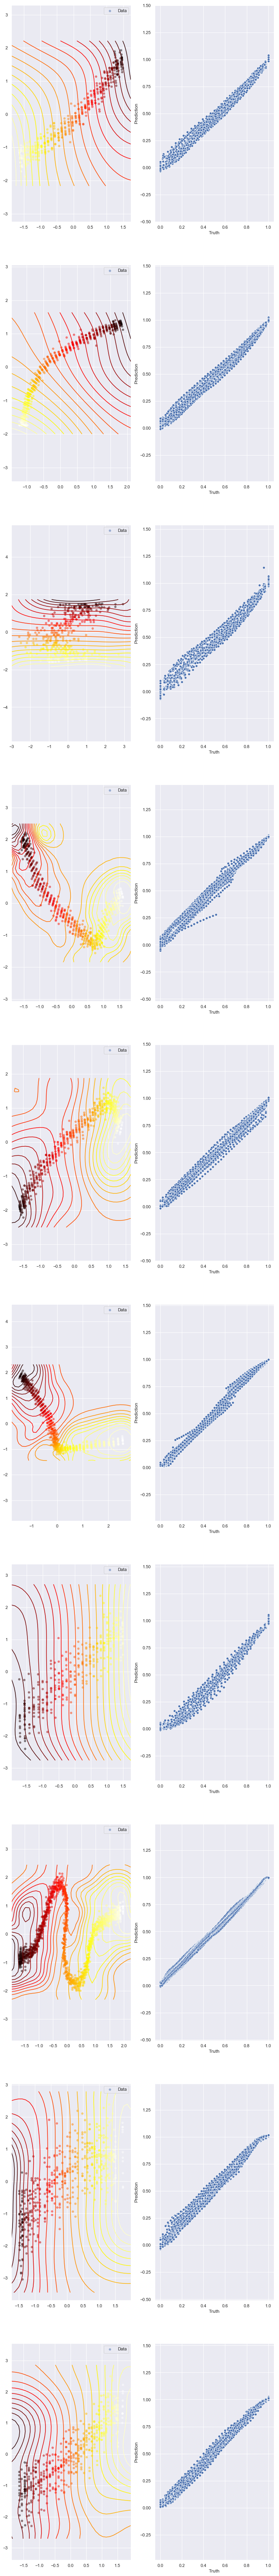

In [32]:
def synch_data(synch_gp, data):
    latlon = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(xy, axis=1)
    return synched_data

test = pd.read_pickle('test.pkl')
print(len(test))
n_segs = test.seg.unique()
_fig, axs = plt.subplots(nrows=len(n_segs), ncols=2, figsize=(12, int(12*len(n_segs))))
for i, seg_n, model in zip(range(len(n_segs)), n_segs, gps.values()):
    seg = test[test.seg == seg_n]
    #print(len(test))
    #print('####SEG', seg)
    X = seg[['lat', 'lon']].values
    tau, _var = gp.predict(gps[int(seg_n)], X)
    df = pd.DataFrame({'Prediction': tau.T[0], 'Truth': seg.progress})
    model.model.plot(ax=axs[i, 0])
    axs[i, 0].set_aspect('equal', 'datalim')
    sns.scatterplot(data=df, x='Truth', y='Prediction', ax=axs[i, 1])
    axs[i, 1].set_aspect('equal', 'datalim')

In [33]:
for model in gps.values():
     gp.save(model)

A final test of the load functions and plotting of (training) predictions

FileNotFoundError: [Errno 2] No such file or directory: './gps/synch-3/3.0.2.pkl'

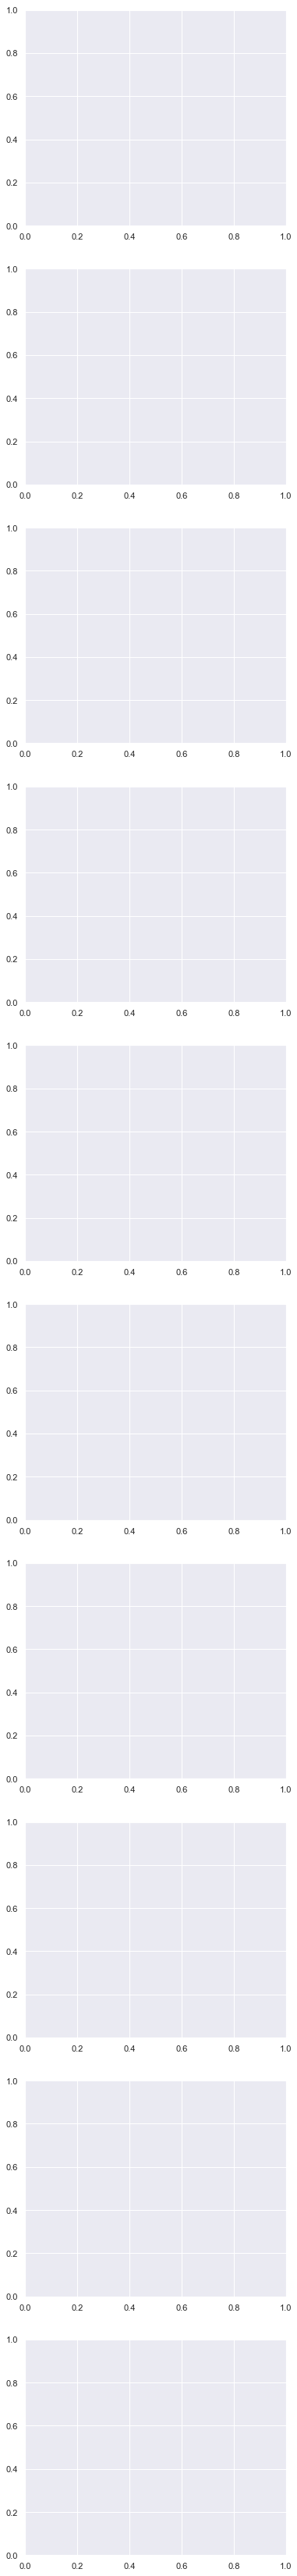

In [29]:
traj = train[train.traj == traj_n]
_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for i, seg_n in zip(range(len(n_segs)), n_segs):
    seg = traj[traj.seg == seg_n]
    sgp = gp.load_synch(route_n, seg_n, version=version)
    X = seg[['lat', 'lon']].values
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[i])